In [13]:
# %%
import os, glob, random, time
import csv
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.metrics.functional import get_stats, iou_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import cv2

In [24]:
# -----------------------
# Configuration
# -----------------------
POLYP_DATASET = {
    'kvasir': 'Kvasir-SEG',
    'cvc_clinic': 'CVC-ClinicDB',
    'polypgen': 'PolypGen',
    'cvc_colon': 'CVC-ColonDB'
}
IMG_SIZE     = 256
BATCH_SIZE   = 16
TEST_SPLIT   = 0.2
LR           = 1e-4
EPOCHS       = 100
SEED         = 42
PATIENCE     = 5
ENCODER      = 'efficientnet-b4'
ENC_WEIGHTS  = 'imagenet'
DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name    = 'FPNv3'
eval_filename = f'{model_name}_evaluation_results.csv'
weights_path  = f'{model_name}.pth'

print("\nDevice: ", DEVICE)


Device:  cuda


In [25]:
# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [26]:
# -----------------------
# Dice Coefficient
# -----------------------
def dice_coef(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

In [27]:
# -----------------------
# Dataset Definition (Without ROI Cropping)
# -----------------------
class PolypSegDataset(Dataset):
    def __init__(self, img_paths, mask_paths, augment=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.augment = augment or A.Compose([  # Default transforms if none provided
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.Normalize(),
            ToTensorV2()
        ], is_check_shapes=False)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load original full-size image and mask
        img = np.array(Image.open(self.img_paths[idx]).convert('RGB'))
        mask = np.array(Image.open(self.mask_paths[idx]).convert('L'))

        # Apply augmentations/resizing
        transformed = self.augment(image=img, mask=mask)

        # Convert to tensors and normalize mask
        img_t = transformed['image']
        msk_t = transformed['mask'].unsqueeze(0).float() / 255.0  # [1,H,W] in [0,1]

        return img_t, msk_t

In [28]:
# -----------------------
# Data Loading
# -----------------------
def split_dataset(img_paths, mask_paths, test_ratio=TEST_SPLIT):
    """Split a dataset into train/val while maintaining pairs"""
    assert len(img_paths) == len(mask_paths), "Mismatched image-mask pairs"
    idxs = list(range(len(img_paths)))
    random.shuffle(idxs)
    split = int(len(idxs) * (1 - test_ratio))
    return (
        [img_paths[i] for i in idxs[:split]], [mask_paths[i] for i in idxs[:split]],  # train
        [img_paths[i] for i in idxs[split:]], [mask_paths[i] for i in idxs[split:]]   # val
    )

# 1) Split Kvasir and CVC-ClinicDB into train/val
kvasir_train_imgs, kvasir_train_msks, kvasir_val_imgs, kvasir_val_msks = split_dataset(
    sorted(glob.glob(os.path.join(POLYP_DATASET['kvasir'], 'images', '*.*'))),
    sorted(glob.glob(os.path.join(POLYP_DATASET['kvasir'], 'masks', '*.*')))
)

cvc_train_imgs, cvc_train_msks, cvc_val_imgs, cvc_val_msks = split_dataset(
    sorted(glob.glob(os.path.join(POLYP_DATASET['cvc_clinic'], 'Original', '*.*'))),
    sorted(glob.glob(os.path.join(POLYP_DATASET['cvc_clinic'], 'Ground Truth', '*.*')))
)



# 2) Combine train/val from Kvasir + CVC-ClinicDB only
train_imgs = kvasir_train_imgs + cvc_train_imgs
train_msks = kvasir_train_msks + cvc_train_msks
val_imgs = kvasir_val_imgs + cvc_val_imgs
val_msks = kvasir_val_msks + cvc_val_msks

# 3) External test sets (PolypGen + CVC-ColonDB)
polypgen_imgs = sorted(glob.glob(os.path.join(POLYP_DATASET['polypgen'], 'images', '*.*')))
polypgen_msks = sorted(glob.glob(os.path.join(POLYP_DATASET['polypgen'], 'masks', '*_mask.*')))
ec_imgs = sorted(glob.glob(os.path.join(POLYP_DATASET['cvc_colon'], 'images', '*.*')))
ec_msks = sorted(glob.glob(os.path.join(POLYP_DATASET['cvc_colon'], 'masks', '*.*')))

# Verify no leakage
assert not set(train_imgs) & set(val_imgs), "Train/val leakage in images!"
assert not set(polypgen_imgs) & set(train_imgs + val_imgs), "PolypGen leaked into train/val!"
assert not set(ec_imgs) & set(train_imgs + val_imgs), "CVC-ColonDB leaked into train/val!"


# Augmentations
a_train = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
    A.Affine(translate_percent=0.10, scale=0.7, rotate=45, p=0.5),
    A.ElasticTransform(alpha=120, sigma=6, interpolation=1, border_mode=0, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=0, p=0.3),
    A.RandomGamma(gamma_limit=(80,120), p=0.3),
    A.OneOf([
        A.GaussianBlur(blur_limit=3, p=1.0),
        A.MotionBlur(blur_limit=5, p=1.0),
    ], p=0.2),
    A.Normalize(),
    ToTensorV2()
], is_check_shapes=False, additional_targets={"mask":"mask"})
a_val = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
], is_check_shapes=False)

# DataLoaders with num_workers=0 to prevent hang
dtrain = PolypSegDataset(train_imgs, train_msks, augment=a_train)
dval = PolypSegDataset(val_imgs, val_msks, augment=a_val)
train_loader = DataLoader(dtrain, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(dval, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


# External
polypgen_test = PolypSegDataset(polypgen_imgs, polypgen_msks, augment=a_val)
cvccolon_test = PolypSegDataset(ec_imgs, ec_msks, augment=a_val)
polypgen_loader = DataLoader(polypgen_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
cvccolon_loader = DataLoader(cvccolon_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"\nDataset Sizes:")
print(f"Train:       {len(train_imgs)} (Kvasir + CVC-ClinicDB)")
print(f"Validation:  {len(val_imgs)} (Kvasir + CVC-ClinicDB)")
print(f"Test (CVC-ColonDB): {len(ec_imgs)}")
print(f"Test (PolypGen):    {len(polypgen_imgs)}")



Dataset Sizes:
Train:       1289 (Kvasir + CVC-ClinicDB)
Validation:  323 (Kvasir + CVC-ClinicDB)
Test (CVC-ColonDB): 380
Test (PolypGen):    1537


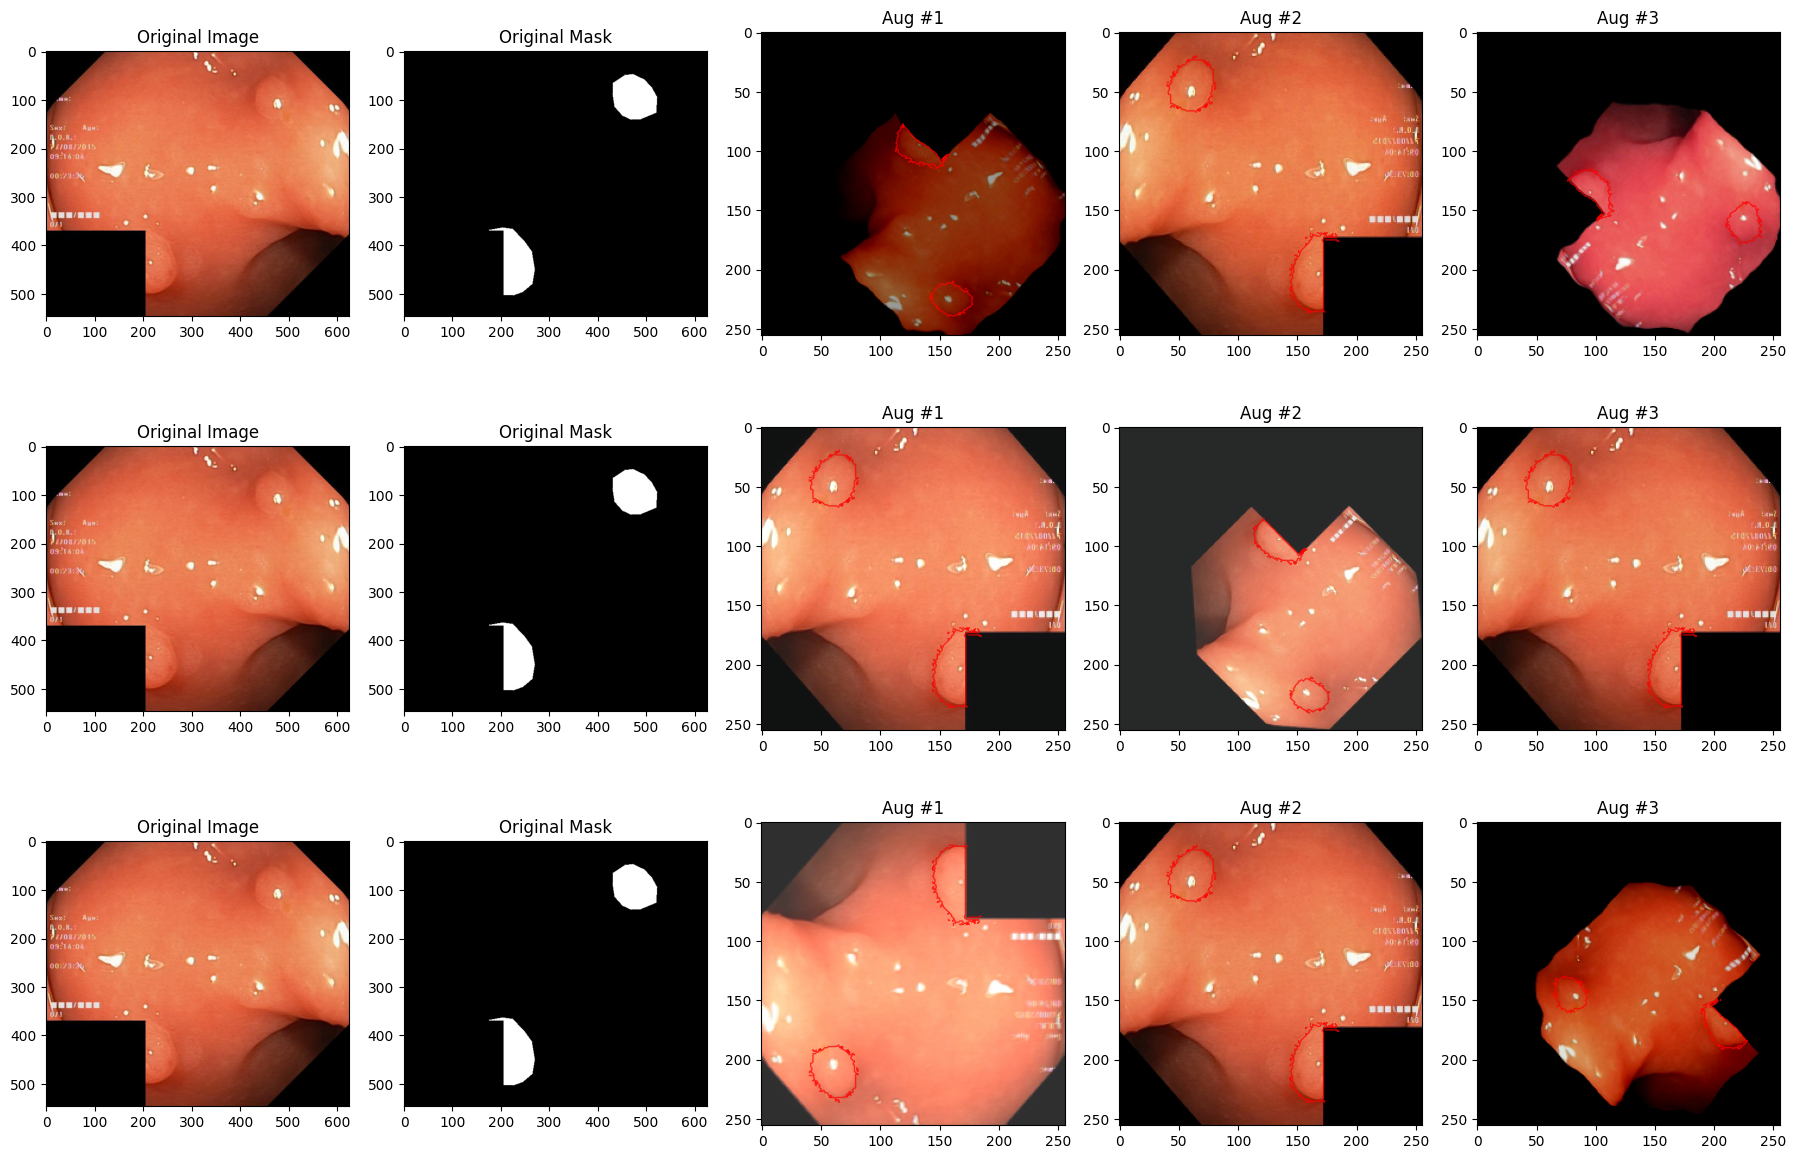

In [29]:
def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    return np.clip(image * std + mean, 0, 1)

def visualize_augmentations(dataset, idx=0, samples=3):
    fig, ax = plt.subplots(samples, 5, figsize=(18, samples*4))

    for i in range(samples):
        # Load fresh image/mask pair each time
        img = np.array(Image.open(dataset.img_paths[idx]).convert('RGB'))
        mask = np.array(Image.open(dataset.mask_paths[idx]).convert('L'))

        # Original (before any transforms)
        ax[i,0].imshow(img)
        ax[i,0].set_title("Original Image")
        ax[i,1].imshow(mask, cmap='gray')
        ax[i,1].set_title("Original Mask")

        # Apply augmentations 3 times
        for j in range(3):
            augmented = dataset.augment(image=img, mask=mask)
            aug_img = denormalize(augmented['image'])
            aug_mask = augmented['mask'].squeeze().numpy() if isinstance(augmented['mask'], torch.Tensor) else augmented['mask']

            ax[i,j+2].imshow(aug_img)
            ax[i,j+2].set_title(f"Aug #{j+1}")

            # Add mask contours
            contours, _ = cv2.findContours(
                (aug_mask * 255).astype(np.uint8),
                cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            for contour in contours:
                ax[i,j+2].plot(contour[:,0,0], contour[:,0,1], color='red', linewidth=1, alpha=0.7)

    plt.tight_layout()
    plt.show()
    # Usage
visualize_augmentations(dtrain, idx=0, samples=3)

In [31]:
# -----------------------
# Model, Loss, Optimizer
# -----------------------
model = smp.UnetPlusPlus(encoder_name=ENCODER, encoder_weights=ENC_WEIGHTS,
                 in_channels=3, classes=1).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=3e-5)
writer = SummaryWriter(log_dir='runs/polyp_seg')

In [32]:
# -----------------------
# Training Loop
# -----------------------
scaler = torch.amp.GradScaler()

best_iou = 0.0
no_improve = 0
for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0.0
    for imgs, msks in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)
        optimizer.zero_grad()
        # Mixed precision forward pass
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits = model(imgs)
            loss = criterion(logits, msks) + (1 - dice_coef(torch.sigmoid(logits), msks))
        # Backward pass with scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)

    model.eval()
    val_iou = 0.0
    with torch.no_grad():
        for imgs, msks in val_loader:
            imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)

            # 1) get raw probabilities
            preds = torch.sigmoid(model(imgs))      # float32 in [0,1]

            # 2) binarize & cast both preds and masks to long
            preds_mask = (preds > 0.5).long()       # ints 0 or 1
            msks_int   = msks.long()                # masks were floats 0.0/1.0 → ints

            # 3) compute pixel-level stats (no threshold arg here)
            tp, fp, fn, tn = get_stats(preds_mask, msks_int, mode='binary')

            # 4) compute IoU from those stats
            batch_iou = iou_score(tp, fp, fn, tn, reduction='micro').item()
            val_iou  += batch_iou

    val_iou /= len(val_loader)
    print(f"Epoch {epoch}: Val IoU: {val_iou:.4f}")
    print(f"Val IoU: {val_iou:.4f}")

    lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Loss/train', avg_loss, epoch)
    writer.add_scalar('IoU/val', val_iou, epoch)
    writer.add_scalar('LR', lr, epoch)
    print(f"Epoch {epoch}: Loss: {avg_loss:.4f}, Val IoU: {val_iou:.4f}, LR: {lr:.6f}")
    scheduler.step()

    if val_iou > best_iou:
        best_iou = val_iou
        no_improve = 0
        torch.save(model.state_dict(), weights_path)
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")


Epoch 1 Training: 100%|██████████| 81/81 [04:05<00:00,  3.03s/it]


Epoch 1: Val IoU: 0.7063
Val IoU: 0.7063
Epoch 1: Loss: 1.1399, Val IoU: 0.7063, LR: 0.000100


Epoch 2 Training: 100%|██████████| 81/81 [04:07<00:00,  3.06s/it]


Epoch 2: Val IoU: 0.7260
Val IoU: 0.7260
Epoch 2: Loss: 0.8752, Val IoU: 0.7260, LR: 0.000100


Epoch 3 Training: 100%|██████████| 81/81 [04:08<00:00,  3.07s/it]


Epoch 3: Val IoU: 0.7226
Val IoU: 0.7226
Epoch 3: Loss: 0.7472, Val IoU: 0.7226, LR: 0.000099


Epoch 4 Training: 100%|██████████| 81/81 [04:08<00:00,  3.06s/it]


Epoch 4: Val IoU: 0.7483
Val IoU: 0.7483
Epoch 4: Loss: 0.6609, Val IoU: 0.7483, LR: 0.000098


Epoch 5 Training: 100%|██████████| 81/81 [04:08<00:00,  3.06s/it]


Epoch 5: Val IoU: 0.7386
Val IoU: 0.7386
Epoch 5: Loss: 0.5642, Val IoU: 0.7386, LR: 0.000096


Epoch 6 Training: 100%|██████████| 81/81 [04:08<00:00,  3.06s/it]


Epoch 6: Val IoU: 0.7580
Val IoU: 0.7580
Epoch 6: Loss: 0.4999, Val IoU: 0.7580, LR: 0.000093


Epoch 7 Training: 100%|██████████| 81/81 [04:05<00:00,  3.03s/it]


Epoch 7: Val IoU: 0.7678
Val IoU: 0.7678
Epoch 7: Loss: 0.4135, Val IoU: 0.7678, LR: 0.000091


Epoch 8 Training: 100%|██████████| 81/81 [04:08<00:00,  3.07s/it]


Epoch 8: Val IoU: 0.7617
Val IoU: 0.7617
Epoch 8: Loss: 0.3848, Val IoU: 0.7617, LR: 0.000087


Epoch 9 Training: 100%|██████████| 81/81 [04:13<00:00,  3.12s/it]


Epoch 9: Val IoU: 0.7620
Val IoU: 0.7620
Epoch 9: Loss: 0.3409, Val IoU: 0.7620, LR: 0.000084


Epoch 10 Training: 100%|██████████| 81/81 [04:42<00:00,  3.48s/it]


Epoch 10: Val IoU: 0.7841
Val IoU: 0.7841
Epoch 10: Loss: 0.3129, Val IoU: 0.7841, LR: 0.000080


Epoch 11 Training: 100%|██████████| 81/81 [04:10<00:00,  3.09s/it]


Epoch 11: Val IoU: 0.7904
Val IoU: 0.7904
Epoch 11: Loss: 0.2880, Val IoU: 0.7904, LR: 0.000076


Epoch 12 Training: 100%|██████████| 81/81 [04:07<00:00,  3.06s/it]


Epoch 12: Val IoU: 0.7887
Val IoU: 0.7887
Epoch 12: Loss: 0.2558, Val IoU: 0.7887, LR: 0.000072


Epoch 13 Training: 100%|██████████| 81/81 [04:06<00:00,  3.04s/it]


Epoch 13: Val IoU: 0.7916
Val IoU: 0.7916
Epoch 13: Loss: 0.2402, Val IoU: 0.7916, LR: 0.000067


Epoch 14 Training: 100%|██████████| 81/81 [04:06<00:00,  3.05s/it]


Epoch 14: Val IoU: 0.7717
Val IoU: 0.7717
Epoch 14: Loss: 0.2247, Val IoU: 0.7717, LR: 0.000063


Epoch 15 Training: 100%|██████████| 81/81 [04:06<00:00,  3.04s/it]


Epoch 15: Val IoU: 0.8140
Val IoU: 0.8140
Epoch 15: Loss: 0.2177, Val IoU: 0.8140, LR: 0.000058


Epoch 16 Training: 100%|██████████| 81/81 [04:06<00:00,  3.04s/it]


Epoch 16: Val IoU: 0.7924
Val IoU: 0.7924
Epoch 16: Loss: 0.2105, Val IoU: 0.7924, LR: 0.000054


Epoch 17 Training: 100%|██████████| 81/81 [04:06<00:00,  3.05s/it]


Epoch 17: Val IoU: 0.8149
Val IoU: 0.8149
Epoch 17: Loss: 0.1930, Val IoU: 0.8149, LR: 0.000050


Epoch 18 Training: 100%|██████████| 81/81 [04:06<00:00,  3.04s/it]


Epoch 18: Val IoU: 0.8056
Val IoU: 0.8056
Epoch 18: Loss: 0.1784, Val IoU: 0.8056, LR: 0.000046


Epoch 19 Training: 100%|██████████| 81/81 [04:06<00:00,  3.05s/it]


Epoch 19: Val IoU: 0.7974
Val IoU: 0.7974
Epoch 19: Loss: 0.1728, Val IoU: 0.7974, LR: 0.000043


Epoch 20 Training: 100%|██████████| 81/81 [04:08<00:00,  3.06s/it]


Epoch 20: Val IoU: 0.8004
Val IoU: 0.8004
Epoch 20: Loss: 0.1663, Val IoU: 0.8004, LR: 0.000039


Epoch 21 Training: 100%|██████████| 81/81 [04:12<00:00,  3.12s/it]


Epoch 21: Val IoU: 0.8047
Val IoU: 0.8047
Epoch 21: Loss: 0.1611, Val IoU: 0.8047, LR: 0.000037


Epoch 22 Training: 100%|██████████| 81/81 [04:07<00:00,  3.05s/it]


Epoch 22: Val IoU: 0.8128
Val IoU: 0.8128
Epoch 22: Loss: 0.1499, Val IoU: 0.8128, LR: 0.000034
Early stopping at epoch 22


In [44]:
# -----------------------
# Final Evaluation & Visualization
# -----------------------

def evaluate_model(loader, model, device, dataset_name=""):
    model.eval()
    iou_scores, dice_scores = [], []
    vis_dir = "prediction_visualizations"
    os.makedirs(vis_dir, exist_ok=True)

    with torch.no_grad():
        for batch_idx, (imgs, masks) in enumerate(loader):
            imgs, masks = imgs.to(device), masks.to(device)
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                probs = torch.sigmoid(model(imgs))
            preds = (probs > 0.5).long()
            masks = masks.long()

            # Compute metrics
            tp, fp, fn, tn = get_stats(preds, masks, mode='binary')
            batch_iou = iou_score(tp, fp, fn, tn, reduction='micro').item()
            batch_dice = dice_coef(probs, masks).item()
            iou_scores.append(batch_iou)
            dice_scores.append(batch_dice)

            # Save sample predictions (first batch only)
            if batch_idx == 0 and dataset_name:
                for i in range(min(4, len(imgs))):  # FIXED: Added missing )
                    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                    # Denormalize image if needed
                    img_to_show = imgs[i].cpu().permute(1, 2, 0).numpy()
                    if img_to_show.min() < 0 or img_to_show.max() > 1:  # Check if normalized
                        img_to_show = (img_to_show - img_to_show.min()) / (img_to_show.max() - img_to_show.min())

                    axes[0].imshow(img_to_show)
                    axes[0].set_title("Input Image")
                    axes[1].imshow(masks[i].cpu().squeeze(), cmap='gray')
                    axes[1].set_title("Ground Truth")
                    axes[2].imshow(preds[i].cpu().squeeze(), cmap='gray')
                    axes[2].set_title("Prediction")
                    plt.savefig(f"{vis_dir}/{dataset_name}_sample_{i}.png", bbox_inches='tight', dpi=100)
                    plt.close()

    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    return mean_iou, mean_dice

# 1) Load the best model
model.load_state_dict(torch.load(weights_path))
model.to(DEVICE)

# 2) Evaluate per dataset
test_loaders = {
    "Validation": val_loader,
    "CVC-ColonDB": cvccolon_loader,
    "PolypGen": polypgen_loader
}

results = []
for name, loader in test_loaders.items():
    iou, dice = evaluate_model(loader, model, DEVICE, name)
    results.append((name, iou, dice))  # FIXED: Store results before printing
    print(f"{name}:")
    print(f"- IoU: {iou:.4f}")
    print(f"- Dice: {dice:.4f}\n")

# 3) Save to CSV
with open(eval_filename, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Dataset', 'IoU', 'Dice'])
    for name, iou, dice in results:
        writer.writerow([name, f"{iou:.4f}", f"{dice:.4f}"])

print(f"✅ Evaluation saved to {eval_filename}")

Validation:
- IoU: 0.8415
- Dice: 0.9000

CVC-ColonDB:
- IoU: 0.6648
- Dice: 0.7469

PolypGen:
- IoU: 0.4980
- Dice: 0.5900

✅ Evaluation saved to Segformer_evaluation_results.csv
